# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `<34>`
* Students: `<Valentin Morel, Xavier Sieber, Cédric Schumacher, Charles-Théophile Coen>`
* Dataset: `<Terrorist attack>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load('Adjacency1.npy') # Your code here.

# Suppression of the nodes with 0 degree (otherwise problem when computing the normalized Laplacian)
degree = adjacency.sum(axis=0)
list_to_delete = []; # This array is going to contain all the index of the nodes with degree 0

for i in range(0,len(adjacency)):
    degree_node_i = degree.item(i)
    
    if degree_node_i == 0:
        list_to_delete.append(i)
        
list_to_delete = np.array(list_to_delete)

for j in range(0,len(list_to_delete)): 
    index = list_to_delete[j]
    adjacency = np.delete(adjacency, index, axis=0)
    adjacency = np.delete(adjacency, index, axis=1)
    list_to_delete = list_to_delete - 1 

degree = adjacency.sum(axis=0)
n_nodes = len(adjacency) # Your code here.

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
adjacency = sparse.csr_matrix(adjacency) # Transformation of the adjacency matrix to a CSR matrix

D = sparse.diags(degree) # Degree matrix
D2 = sparse.diags(1/np.sqrt(degree)) # Represent D^(-1/2)

laplacian_combinatorial = D - adjacency # Your code here.
laplacian_normalized =  D2.dot(laplacian_combinatorial.dot(D2)) # Your code here.

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
laplacian =  laplacian_normalized # Either laplacian_combinatorial or laplacian_normalized.

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
# calculate eigendecomposition
values, vectors = np.linalg.eigh(laplacian.toarray())

eigenvectors = vectors # Your code here.
eigenvalues = np.round(np.absolute(values),2) # Your code here.

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Your answer here.**
'''
Dépend de notre matrice L si elle est réelle np suddit je pense. mais avec sparse on peut choisir le nomvre de vect. propre désiré
'''

As our laplacian matrix is a sparse matrix, it would be logical to use the function sparse.linalg.eigs() in order to find the eigen decomposition. Unfortunately, with this function, we can only get N-1 eigenvalues. Thus, in order to find all the eigenvalues of the laplacian, we transformed our matrix to a np.ndarray in order to use the function np.linalg.eigh(), which gives us the complete decomposition for a Hermitian matrix.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

$S$ is the incidence matrix. It takes as input a node ($n_i$) and an edge ($e_j$). For directed graph we have:
* If the edge $e_j$ is going from $n_i$ to $n_k$, the value $S[i,j]$ of the matrix is going to be 1 
* If the edge $e_j$ is going from $n_k$ to $n_i$, the value $S[i,j]$ of the matrix is going to be -1 
* If the edge $e_j$ is not related to $n_i$, the value $S[i,j]$ of the matrix is going to be 0

For undirected graph, if the edge $e_j$ is going from $n_i$ to $n_k$ or the other way around, the value $S[i,j]$ of the matrix is going to be 1.

Each row of the $S^\top$ matrix is going to have two values only: a $+1$ at the node corresponding to the head of the edge, and a $-1$ at the node corresponding to the tail of the edge. The vector $x$ attributes a values for each node, and therefore, the product $S^\top x$ represents the difference between the two numbers given to the two nodes of an edge. This is correct for directed graph.

For undirected graph, the product $S^\top x$ represents the addition of the two numbers given to the nodes of an edge.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

PAS COMPLET peut-être début de la résolution dans chapitre Laplacian Eigenmaps slide 9, mais pas sûr

$u_k^\top \lambda_k = u_k^\top L u_k = u_k^\top S S^\top u_k = \| S^\top u_k \|_2^2 $


What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

The quantity $\| S^\top x \|_2^2$ tell us the difference, or derivative, of the vector $x$ along all the edges of our graph. 

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your annswer here.**

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

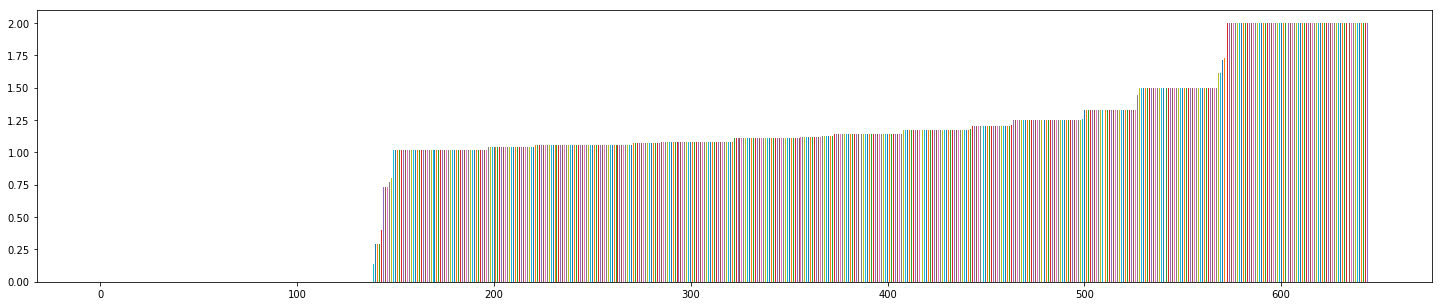

In [7]:
plt.figure(figsize=(25, 5))
for i in range(0, len(eigenvalues)):
    plt.bar(i,eigenvalues[i], width=0.5)
plt.show()

**Your answer here.**

An interesting part of the spectrum that we can see on both Laplacian, is the eigenvalues equal to 0. For both, the combinatorial and normalized Laplacian, we have 139 eigenvalues equal to 0. From the theory, we know that the multiplicity of the eivenvalue 0 is equal to the number of connected components.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [8]:
# Your code here.
number_connected_components = len(eigenvalues)- np.count_nonzero(eigenvalues)

print('Number of connected componenets equal to', number_connected_components)

Number of connected componenets equal to 139


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

For the combinatorial Laplacian, there are no theoretical largest value for the engienvalue. However, we saw in the theory that the normalized Laplacian is bound to an upper value equal to 2.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**
'''
Laplacian eigenmaps are used for nonlinear dimensionality reduction. 
Traditional techniques like PCA don't consider the intrinsic geometry of the data.
So Laplacian eigenmaps builds a graph from neighborhood information of the data set. Each data point serves as a node on the graph and connectivity between nodes is governed by the proximity of neighboring points (using e.g. the k-nearest neighbor algorithm). The graph thus generated can be considered as a discrete approximation of the low-dimensional manifold in the high-dimensional space.
'''

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [9]:
# Your code here.

val, vect = sparse.linalg.eigsh(laplacian, k = number_connected_components, which = 'SM')

Plot the nodes embedded in 2D. Comment on what you see.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
# Your code here.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**